# `DeepGalerkin`-model: solving PDEs with NNs

Welcome! In this tutorial you'll learn how to solve partial differential equations (PDEs) with neural networks using `DeepGalerkin`-model from `BatchFlow`. The notebook
* starts with general setup of the PDE solved by `DeepGalerkin`
* then explains in detail how the model is configured
* finally, demonstrates how to use the model for solving common pde-problems, including *2nd-order ordinary differential equation*, *heat-equation* and *wave-equation*.

To get full understanding of `DeepGalerkin`, we suggest you to read this tutorial starting from the problem setup. The alternative is to jump [straight to the working examples](#exs).

**Note**: `DeepGalerkin` is written in [TensorFlow](https://www.tensorflow.org/). Throughout the notebook `tf` will stand for `TensoFlow`.

## Setup of the PDE-problem

Currently, `DeepGalerkin` supports equations of up to the second order with constant coefficients with `Dirichlet` boundary and initial conditions. In general form, the PDE-
problem looks as follows:
<a id='eq'></a>
$$
\sum_i a_i \frac{\partial u}{\partial x_i} + \sum_{i j} b_{i j} \frac{\partial^2 u}{\partial x_i \partial x_i}  = Q(x). \\
$$
Where $a_{ij}, b_i $ -  arbitrary constants. PDE is solved on the domain
<a id='dom'></a>
$$
\Omega = [b_0^1, b_1^1] \times \dots \times [b_0^n, b_1^n] ,\quad u: \mathcal{R}^n \rightarrow \mathcal{R}
$$
$x$ is $(x_1, \dots, x_n)$. In many tasks, $x_n$ represents time-dimension $t$. In that case, the initial conditions fix the initial state and evolution rate of the system:
<a id='inc_0'></a>
$$
u(x_1, \dots, x_{n-1}, b_0^n) = u_0(x_1, \dots, x_{n-1}),
$$
<a id='inc_1'></a>
$$
\frac{\partial u(x_1, \dots, x_{n-1}, b_0^n)}{\partial t} = u_0'(x_1, \dots, x_{n-1}).
$$
When only first-order time derivative is presented in lhs of PDE, only the initial value of system is needed:
$$
u(x_1, \dots, x_{n-1}, b_0^n) = u_0(x_1, \dots, x_{n-1}),
$$
With `Dirichlet`-boundary conditions:
<a id='inc_3'></a>
$$
u(\sigma \Omega) = u_{\sigma}.
$$

The main idea of `DeepGalerkin` is to fit the parameters $\theta$ of network $net(x; \theta)$ so that the difference between left-hand-side (lhs) of the PDE and right-hand-size (rhs) be small:
<a id='dist'></a>
$$
Loss(\theta) = \int \limits_{\Omega} L\left(\sum_i a_i \frac{\partial net(x; \theta)}{\partial x_i} + \sum_{i j} b_{i j} \frac{\partial^2 net(x; \theta)}{\partial x_i \partial x_i} - Q(x)\right)  \mathcal{P}( d x) \rightarrow \min\limits_{\theta}.
$$

**Note:** In practice, $Loss(\theta)$ is estimated on a sample(batch) of points $\{(x^i_1,\dots, x^i_n)\}_{i=1,\dots,N}$.
As the distribution $\mathcal{P}$ is not fixed, any sampling scheme can be used.

## Configuring `DeepGalerkin`

Configuring `DeepGalerkin` comes down to
* specification of the equation solved by the model in `common`-dict
* setting other parameters of the model inherited from base-class [`batchflow.models.TfModel`](https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.base.html), e.g. network-architecture and loss-function
* configuring how to form batches of training data and feed them into the training loop

### 1.PDE setup in `common`-dict

It consists of several steps:
* describing lhs of the [equation](#eq): define coefficients $a_{i}, b_{ij}$. This corresponds to the key `form`:
```
'form' : {'d1': v, 'd2': m}
```
where `v` is a vector of $a_i$ and $m$ is a matrix of $b_{ij}$. The number of coefficients in $v$ (alternatively, rows/lines in $m$) defines the dimensionality of the problem.
* setting rhs ($Q$) of the [equation](#eq):
```
'Q' : tf_callable
```
where `tf_callable` is a callable, that accepts `tf`-tensor of shape `(batch_size, pde_dimensionality)` and returns a `tf`-tensor of shape `(batch_size, )`.
* defining the [domain](#dom) of the problem:
```
'domain' : [[b_0^1, b_1^1],...,[b_0^n, b_1^n]]
```
**Note**: if the key is not specified, the domain is set to `[[0, 1],...,[0, 1]]`
* setting initial/boundary conditions. In case of PDEs with time-variable, e.g. heat-equation, one needs to fix initial value of the system ($u(x_1, \dots, x_n, t=0)$) using `initial_condition`:
```
'initial_condition': tf_callable
```
where `tf_callable` accepts `tf`-tensor of shape `(batch_size, pde_dimensionality - 1)` and returns `tf`-tensor of shape `(batch_size, )`. Importantly, when $\frac{\partial^2{u}}{\partial{t^2}}$ is presented in lhs of the [equation](#eq) (e.g. wave equation), one needs to fix **both** initial value and initial rate of the system ($\frac{\partial{u}}{\partial{t}}(x_1, \dots, x_n, t=0)$):
```
'initial_condition': (tf_callable_1, tf_callable_2)
```
When `initial_condition` is not present in configuration-dict, `boundary-condition` [$u_{\sigma}$](#inc_3) must be supplied:
```
'boundary_condition': constant
```
* [optional] choosing the mode of `time_multiplier`: a multiplier, used for binding initial conditions. Can be either `sigmoid` or `polynomial` or callable. Go [here](https://github.com/analysiscenter/batchflow/blob/deep_galerkin/batchflow/models/tf/deep_galerkin.py#L150) for more info.

### 2. Setting other parameters of `DeepGalerkin`

The easiest way to choose the architecture of network $net(x; \theta)$ is to use [batchflow's convolution block](https://analysiscenter.github.io/batchflow/intro/tf_layers.html) in [network's body](https://analysiscenter.github.io/batchflow/intro/tf_models.html). For instance, this combination of keys
```
'body':{'layout' : 'fa fa f',
        'units' : [10, 15, 1],
        'activation' : [tf.nn.tanh, tf.nn.tanh]}
```
corresponds to a `f`ully-connected network with two hidden layers (of 10 and 15 units), one output-unit and two `tanh`-`a`ctivations. The specification of `loss` and other parameters is straightforward:
```
'loss':'mse'
```

### 3. Setting up the data-feeding procedure
It consists of two steps

* choosing the sampling scheme from $\Omega$ (fixing the distribution $\mathcal{P}$).
The most convenient way is to use [`Sampler`-class](https://github.com/analysiscenter/batchflow/blob/master/examples/tutorials/07_sampler.ipynb). For instance, this line
```
s = (0.5 + NumpySampler('normal', dim=2)).truncate((1, 1), (0, 0)) 
```
creates an object, that can sample points from a 2-dimensional Gaussian with center at $(0.5, 0.5)$ truncated into the box $[0, 1] \times [0, 1]$:
```
sample_of_size_10 = s.sample(size=10)
```
* feeding sampled batches into the network-training loop. The easiest way is to wrap a callable, that samples points (`s.sample` in our example), into a [batchflow's named expression L](https://analysiscenter.github.io/batchflow/intro/named_expr.html):
```
pipeline = (Pipeline()
            .init_model(name='galerkin', ...)                       # model initialization
            .train_model('galerkin',
                         feed_dict={'points': L(s.sample, size=F(len))}  # wrapped sampler
                         ))
```

<a id='exs'></a>

## Examples: Solving common PDEs with `DeepGalerkin`

In [1]:
import tensorflow as tf
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
from batchflow.models.tf import DeepGalerkin
from batchflow import Pipeline, L, F, V, DatasetIndex, Dataset
import numpy as np
from batchflow import NumpySampler
from batchflow.sampler import cart_prod
from tqdm import tqdm_notebook

* first-order ordinary differential equation in $\mathcal{R}$ with simple initial condition
$$
\frac{d f}{d t}= 2\pi\cos[2 \pi t]; \quad t \in [0, 1],\ f(0)=1.
$$

In [2]:
# describing pde-problem in common-dict
common = {'form': {'d1': (1, )},
          'Q': lambda t: 2 * np.pi * tf.cos(2 * np.pi * t),
          'initial_condition': 1,                         # will be transformed into callable returning 1
          'time_multiplier': 'sigmoid',
          'bind_bc_ic': True}

# network-architecture and loss-function
body = {'layout': 'fa fa f',
        'units': [10, 15, 1],
        'activation': [tf.nn.tanh, tf.nn.tanh]}
loss = 'mse'

# put it together in model-config
config = {'inputs': dict(points={'shape': (1, )}),
          'initial_block/inputs': 'points',
          'body': body,
          'common': common,
          'loss': loss}

# uniform sampling scheme
s = NumpySampler('u')

In [3]:
# assemble training pipeline
pipeline = (Pipeline()
            .init_variable('loss', default=[])
            .init_variable('dt', default=[])
            .init_model('static', DeepGalerkin, 'DG', config)
            .train_model('DG',
                         feed_dict={'points': L(s.sample, size=F(len))},
                         fetches='loss',
                         save_to=V('loss'), mode='a'))

dsix = DatasetIndex(np.arange(100))
pipeline_ds = Dataset(dsix) >> pipeline

# train the network on batches of 50 points
for i in tqdm_notebook(range(2000)):
    pipeline_ds.next_batch(20, n_epochs=None)

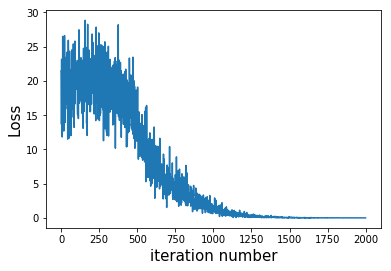

In [4]:
# plot loss
plt.plot(pipeline_ds.get_variable('loss')[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
pass

In [5]:
# fetch trained model
dg = pipeline_ds.get_model_by_name('DG')

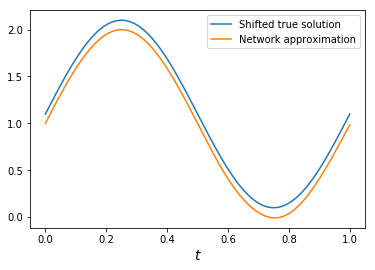

In [6]:
# plot real solution and network approximation
sol = lambda t: np.sin(2 * np.pi * t) + 1
pts = np.linspace(0, 1, 200).reshape(-1, 1)
approxs = dg.predict(feed_dict={'points': pts})
true = [sol(t[0]) + 0.1 for t in pts]
plt.plot(pts, true, label='Shifted true solution')
plt.plot(pts, approxs, label='Network approximation')
plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()

* poisson equation in $\mathcal{R}^2$ with Dirichlet boundary condition

$$\frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} = 5\sin[\pi(x + y)];\quad (x, y) \in [0, 1]^2,\ f(0, y)=f(x, 0)=1.
$$

In [7]:
# describing pde-problem in common-dict
common = {'form': {'d2': ((1, 0), (0, 1))},
          'Q': lambda x: 5 * tf.sin(np.pi * tf.reduce_sum(x, axis=1, keepdims=True)),
          'boundary_condition': 1,                        # will be transformed into callable returning 1
          'bind_bc_ic': True}

# network-architecture and loss-function
body = {'layout': 'fa fa fa f',
        'units': [15, 25, 15, 1],
        'activation': [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh]}
loss = 'mse'

# put it together in model-config
config = {'inputs': dict(points={'shape': (2, )}),
          'initial_block/inputs': 'points',
          'body': body,
          'common': common,
          'loss': loss}

# uniform sampling scheme
s = NumpySampler('u', dim=2)

In [8]:
# assemble training pipeline
pipeline = (Pipeline()
            .init_variable('loss', default=[])
            .init_variable('dt', default=[])
            .init_model('static', DeepGalerkin, 'DG', config)
            .train_model('DG',
                         feed_dict={'points': L(s.sample, size=F(len))},
                         fetches='loss',
                         save_to=V('loss'), mode='a'))

dsix = DatasetIndex(np.arange(100))
pipeline_ds = Dataset(dsix) >> pipeline

# train the network on batches of 50 points
for i in tqdm_notebook(range(1500)):
    pipeline_ds.next_batch(50, n_epochs=None)

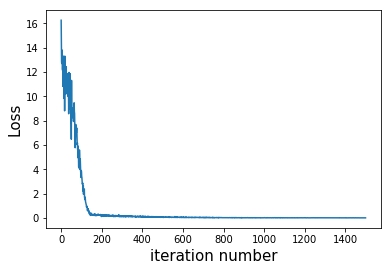

In [10]:
# plot loss
plt.plot(pipeline_ds.get_variable('loss')[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
pass

In [9]:
# fetch trained model
dg = pipeline_ds.get_model_by_name('DG')

Text(0.5, 1.0, 'Elliptic PDE in $dim=2$')

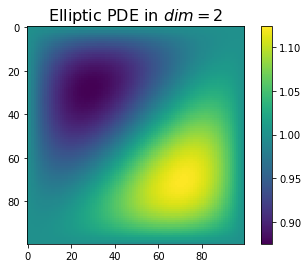

In [11]:
# plot network approximation of a solution
n_el = 100
grid = cart_prod(np.linspace(0, 1, n_el), np.linspace(0, 1, n_el))
approxs = dg.predict(feed_dict={'points': grid})
plt.imshow(approxs.reshape(n_el, n_el))
plt.colorbar()
plt.title('Elliptic PDE in $dim=2$', fontdict={'fontsize': 16})

* heat equation in $\mathcal{R}^2 \times \mathcal{R}$ with Dirichlet initial condition

$$\frac{\partial f}{\partial t} - \frac{\partial^2 f}{\partial x^2} - \frac{\partial^2 f}{\partial y^2} = 5xy(1 - x)(1 - y) \cos[\pi(x + y)];\quad (x, y, t) \in [0, 1]^2 \times [0, 1],\ f(x, y, 0) = xy(1 - x)(1 - y).
$$

In [12]:
# describing pde-problem in common-dict
common = {'form': {'d2': ((-1, 0, 0), (0, -1, 0), (0, 0, 0)),
                   'd1': (0, 0, 1)},
          'Q': lambda x: (5 * tf.cos(np.pi * tf.reduce_sum(x[:, :2], axis=1, keepdims=True))
                          * tf.reduce_prod(x[:, :2], axis=1, keepdims=True)
                          * tf.reduce_prod(1 - x[:, :2], axis=1, keepdims=True)),
          'initial_condition': lambda x:(tf.reduce_prod(x, axis=1, keepdims=True)
                                         * tf.reduce_prod(1 - x, axis=1, keepdims=True)),
          'bind_bc_ic': True}

# network-architecture and loss-function
body = {'layout': 'fa fa fa f',
        'units': [15, 25, 15, 1],
        'activation': [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh]}
loss = 'mse'

# put it together in model-config
config = {'inputs': dict(points={'shape': (3, )}),
          'initial_block/inputs': 'points',
          'body': body,
          'common': common,
          'loss': loss}

# uniform sampling scheme
s = NumpySampler('u', dim=3)

In [15]:
# assemble training pipeline
pipeline = (Pipeline()
            .init_variable('loss', default=[])
            .init_variable('dt', default=[])
            .init_model('static', DeepGalerkin, 'DG', config)
            .train_model('DG',
                         feed_dict={'points': L(s.sample, size=F(len))},
                         fetches='loss',
                         save_to=V('loss'), mode='a'))

dsix = DatasetIndex(np.arange(100))
pipeline_ds = Dataset(dsix) >> pipeline

# train the network on batches of 50 points
for i in tqdm_notebook(range(3500)):
    pipeline_ds.next_batch(200, n_epochs=None)

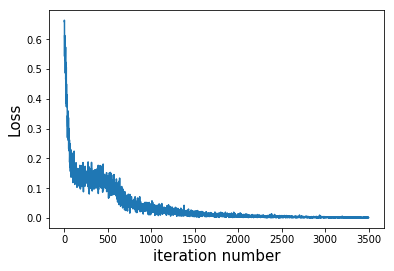

In [20]:
# plot loss
plt.plot(pipeline_ds.get_variable('loss')[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
pass

In [21]:
# fetch trained model
dg = pipeline_ds.get_model_by_name('DG')

Text(0.5, 1.0, 'Parabolic PDE in $\\mathcal{R}^3$; section for $t=0.1$')

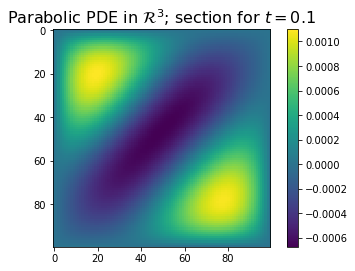

In [67]:
# plot network approximation of a solution
t_ = 0.1
n_el = 100
grid = np.concatenate([cart_prod(np.linspace(0, 1, n_el), np.linspace(0, 1, n_el)),
                       t_ * np.ones(shape=(n_el**2, 1))], axis=1)
approxs = dg.predict(feed_dict={'points': grid})
plt.imshow(approxs.reshape(n_el, n_el))
plt.colorbar()
plt.title('Parabolic PDE in $\mathcal{R}^3$; section for $t=0.1$', fontdict={'fontsize': 16})

* wave equation in $\mathcal{R} \times \mathcal{R}$ with Dirichlet initial conditions

$$\frac{\partial^2 f}{\partial t^2} - \frac{\partial^2 f}{\partial x^2} = x; \quad (x, t) \in [0, 1] \times [0, 1],\ f(x, 0)=\sin(x),\ \frac{\partial f}{\partial t}(x, 0)= x + 1.
$$